# 2-Link Arm
Implementation of a 2-link arm.

![title](img/2-link-robotic-arm.png)

$q = \left[\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2\right] \rightarrow \dot{q} = \left[q_3, q_4, \ddot{q}_1, \ddot{q}_2\right]$

ODE is defined as:

$\ddot{q} = B^{-1}(q)(-C(\dot{q}, q) - g(q) + F)$

With:

$B(q) = \begin{bmatrix}
    (m_1 + m_2)l_1^2 + m_2l_2^2 + 2m_2l_1l_2\cos(q_2) & m_2l_2^2 + m_2l_1l_2\cos(q_2) \\
    m_2l_2^2 + m_2l_1l_2\cos(q_2) & m_2l_2^2 
    \end{bmatrix}\\
C(\dot{q}, q) = \begin{bmatrix}
    -m_2l_1l_2\sin(q_2)(2q_3q_4 + q_4^2) \\
    -m_2l_1l_2\sin(q_2)q_3q_4
    \end{bmatrix}\\
g(q) = \begin{bmatrix}
    -(m_1+m_2)gl_1\sin(q_1) - m_2gl_2\sin(q_1+q_2) \\
    -m_2gl_2\sin(q_1+q_2)
    \end{bmatrix}$

In [1]:
import numpy as np
from scipy.integrate import ode

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib notebook

## Equations of motion

In [3]:
def eom(t, q, params, ths, Kpd):
    m1 , m2, l1, l2, g = params
    q1, q2, q3, q4, q5, q6 = q

    b11 = (m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*np.cos(q2)
    b12 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b21 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b22 = m2*l2**2
    B = np.array([[b11, b12], [b21, b22]])

    c1 = -m2*l1*l2*np.sin(q2)*(2*q3*q4 + q4**2)
    c2 = -m2*l1*l2*np.sin(q2)*q3*q4
    C = np.array([[c1], [c2]])
    
    g1 = -(m1 + m2)*g*l1*np.sin(q1) - m2*g*l2*np.sin(q1 + q2)
    g2 = -m2*g*l2*np.sin(q1 + q2)
    g = np.array([[g1], [g2]])
    
    
    Kp1, Kd1, Ki1, Kp2, Kd2, Ki2 = Kpd        
    th1s, th2s = ths

    f1 = Kp1*(th1s - q1) - Kd1*q3 + Ki1*q5
    f2 = Kp2*(th2s - q2) - Kd2*q4 + Ki2*q6

    Fhat = np.array([[f1], [f2]])

    F = np.dot(B, Fhat)
        
    qdotdot = np.dot(np.linalg.inv(B), -C - g + F)
    
    qdot = [q3, q4] + qdotdot.T[0].tolist() + [th1s-q1, th2s-q2]
        
    return qdot

## Solver
Solve system with with initial position $q_0 = \left[\pi/2, \pi/2, 0., 0.\right]$ and desired position $\theta_s = \left[\pi/2, -\pi/2\right]$. Parameters are set to $m_1 = m_2 = l_1 = l_2 = 1$ and $g = 9.81$.

Solve with simple PID controller, with $K_p = \left[15, 15\right]$ and $K_d = \left[7, 10\right]$ and $K_i = \left[10, 10\right]$.

In [4]:
q0 = [-np.pi/2, np.pi/2, 0., 0., 0., 0.]
ths = (np.pi/2, -np.pi/2)
Ts = 20

m1 = 1
m2 = 1
l1 = 1
l2 = 1
g = 9.81
params = (m1, m2, l1, l2, g)

Kp1 = 15
Kd1 = 7
Ki1 = 10
Kp2 = 15
Kd2 = 10
Ki2 = 10
Kpd = (Kp1, Kd1, Ki1, Kp2, Kd2, Ki2)

r = ode(eom).set_integrator('dopri5')
r.set_initial_value(q0, 0).set_f_params(params, ths, Kpd)
dt = 0.1
sol = []
while r.successful() and r.t < Ts:
    q = r.integrate(r.t + dt)
    sol.append(q)
    
sol = np.array(sol)

## Results

<IPython.core.display.Javascript object>


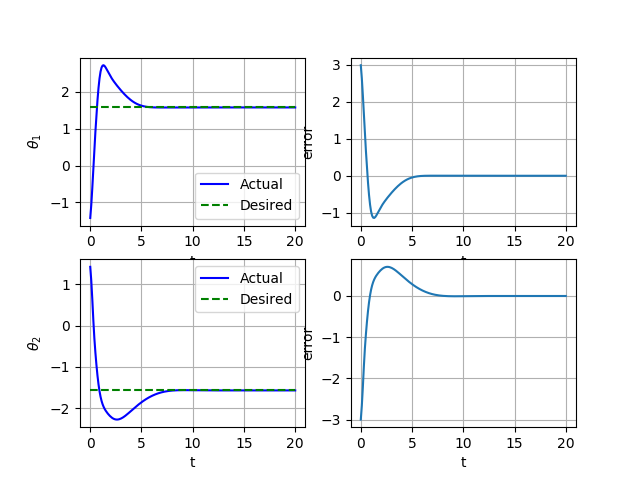

In [5]:
t = np.linspace(0, Ts, Ts*10)

q1d = np.ones(len(t))*ths[0]
q2d = np.ones(len(t))*ths[1]

plt.figure(figsize=(9,4))

plt.subplot(221)
plt.plot(t, sol[:, 0], 'b', label='Actual')
plt.plot(t, q1d, 'g--', label='Desired')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel(r'$\theta_1$')
plt.grid()

plt.subplot(222)
plt.plot(t, q1d-sol[:, 0])
plt.xlabel('t')
plt.ylabel('error')
plt.grid()

plt.subplot(223)
plt.plot(t, sol[:, 1], 'b', label='Actual')
plt.plot(t, q2d, 'g--', label='Desired')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel(r'$\theta_2$')
plt.grid()

plt.subplot(224)
plt.plot(t, q2d-sol[:, 1])
plt.xlabel('t')
plt.ylabel('error')
plt.grid()

### Animation

In [6]:
x1 = np.sin(sol[:, 0])*l1
y1 = np.cos(sol[:, 0])*l1
x2 = x1 + np.sin(sol[:, 0] + sol[:, 1])*l2
y2 = y1 + np.cos(sol[:, 0] + sol[:, 1])*l2

x1d = np.sin(ths[0])*l1
y1d = np.cos(ths[0])*l1

x2d = x1d + np.sin(ths[0] + ths[1])*l2
y2d = y1d + np.cos(ths[0] + ths[1])*l2

<IPython.core.display.Javascript object>


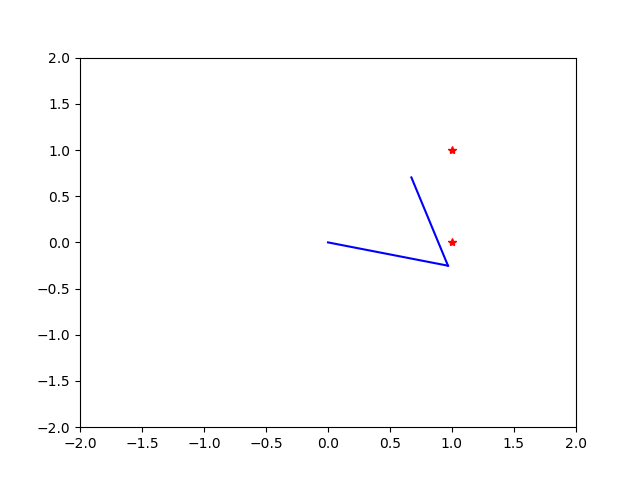

In [7]:
fig, ax = plt.subplots()
ax.set_xlim((-l1-l2, l1+l2))
ax.set_ylim((-l1-l2, l1+l2))
desire_position = ax.plot(x1d, y1d, 'r*')
desire_position = ax.plot(x2d, y2d, 'r*')
line1, = ax.plot([], [], 'b')
line2, = ax.plot([], [], 'b')
lines = [line1, line2]

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return [line1, line2]

def animate(i):
    line1.set_data([0, x1[i]], [0, y1[i]])
    line2.set_data([x1[i], x2[i]], [y1[i], y2[i]])
    return [line1, line2]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=len(x1), blit=True)

## Solve with calculating controls outside of EOM

In [8]:
def eom_new(t, q, u, params):
    m1 , m2, l1, l2, g = params
    u1, u2 = u
    q1, q2, q3, q4 = q
    
    b11 = (m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*np.cos(q2)
    b12 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b21 = m2*l2**2 + m2*l1*l2*np.cos(q2)
    b22 = m2*l2**2
    B = np.array([[b11, b12], [b21, b22]])

    c1 = -m2*l1*l2*np.sin(q2)*(2*q3*q4 + q4**2)
    c2 = -m2*l1*l2*np.sin(q2)*q3*q4
    C = np.array([[c1], [c2]])
    
    g1 = -(m1 + m2)*g*l1*np.sin(q1) - m2*g*l2*np.sin(q1 + q2)
    g2 = -m2*g*l2*np.sin(q1 + q2)
    g = np.array([[g1], [g2]])
    
    Fhat = np.array([[u1], [u2]])
    F = np.dot(B, Fhat)
        
    qdotdot = np.dot(np.linalg.inv(B), -C - g + F)
    
    qdot = [q3, q4] + qdotdot.T[0].tolist()
        
    return qdot

In [17]:
q0 = [-np.pi/2, np.pi/2, 0., 0.]
ths = (np.pi/2, -np.pi/2)
Ts = 20

m1 = 1
m2 = 1
l1 = 1
l2 = 1
g = 9.81
params = (m1, m2, l1, l2, g)

Kp1 = 15
Kd1 = 7
Ki1 = 10
Kp2 = 15
Kd2 = 10
Ki2 = 10

def get_input(q, x_int):
    q1, q2, q3, q4 = q
    u1 = Kp1*(ths[0] - q1) - Kd1*q3 + Ki1*x_int[0]
    u2 = Kp2*(ths[1] - q2) - Kd2*q4 + Ki2*x_int[1]
    return (u1, u2)
    
x_int = [0., 0.]
u0 = get_input(q0, x_int)
f_old = np.array([ths[0]-q0[0], ths[1]-q0[1]])
f_int = np.array([0., 0.])

r = ode(eom_new).set_integrator('dopri5')
r.set_initial_value(q0, 0).set_f_params(u0, params)
dt = 0.1
sol = []

while r.successful() and r.t < Ts:
    q = r.integrate(r.t + dt)
    sol.append(q)
    
    # Calculate integral of error numerically
    f_new = np.array([ths[0]-q[0], ths[1]-q[1]])
    f_int = f_int + (f_old + f_new) * dt / 2.
    f_old = f_new
    x_int = [f_int[0], f_int[1]]
    
    u = get_input(q, x_int)
    
    r.set_f_params(u, params)
    
sol = np.array(sol)

<IPython.core.display.Javascript object>


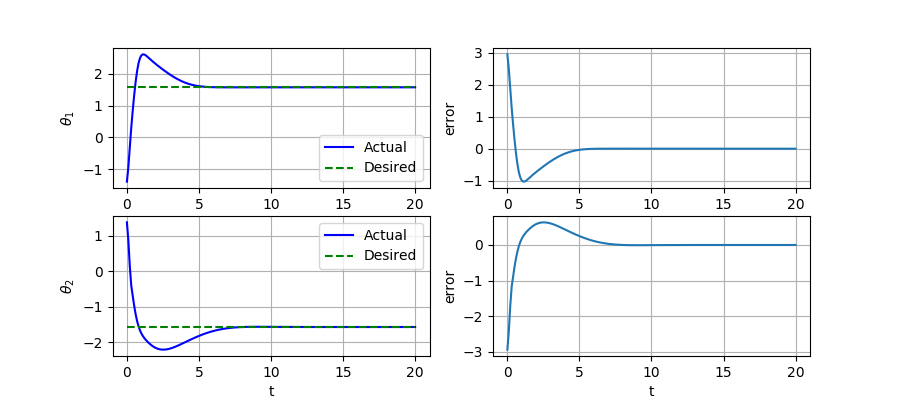

In [23]:
t = np.linspace(0, Ts, Ts*10)

q1d = np.ones(len(t))*ths[0]
q2d = np.ones(len(t))*ths[1]

plt.figure(figsize=(9,4))

plt.subplot(221)
plt.plot(t, sol[:, 0], 'b', label='Actual')
plt.plot(t, q1d, 'g--', label='Desired')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel(r'$\theta_1$')
plt.grid()

plt.subplot(222)
plt.plot(t, q1d-sol[:, 0])
plt.xlabel('t')
plt.ylabel('error')
plt.grid()

plt.subplot(223)
plt.plot(t, sol[:, 1], 'b', label='Actual')
plt.plot(t, q2d, 'g--', label='Desired')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel(r'$\theta_2$')
plt.grid()

plt.subplot(224)
plt.plot(t, q2d-sol[:, 1])
plt.xlabel('t')
plt.ylabel('error')
plt.grid()